# Anomaly Detection Challenge 3
## Miguel Sandim and Paula Fortuna

## 0 - Library Imports & Utils

In [1]:
# pandas
import pandas as pd
from pandas import Series,DataFrame

# numpy, matplotlib, seaborn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Random libraries and seeds:
import random
random.seed(2)
np.random.seed(2)

pd.set_option('display.max_columns', None)

In [2]:
# From: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

######################################
# Function Save Data To CSV
######################################

def saveDataToCSV(Y_pred):
    id_list = range(1, len(Y_pred) + 1)
    submission = pd.DataFrame({
        "Id": id_list,
        "Label": Y_pred
    })
    submission = submission[['Id', 'Label']]
    submission.to_csv('submission.csv', index=False)


# 1 - Data Reading

### 1.1 Load data

In [3]:
# read from csv
train_df = pd.read_csv("data/training-set.csv")
test_df = pd.read_csv("data/testing-set.csv")

In [4]:
train_df["label"].value_counts()

0    56000
1       41
Name: label, dtype: int64

In [5]:
41/(41 + 56000) * 100

0.07316072161453221

## About 0.07% of our dataset are anomalous cases.

# 2 - Data Pre-Processing

In [6]:
import sklearn.preprocessing as skpre

## 2.1 - Solve Missing Values

No missing values exist!

## 2.2 - Feature Extraction

In [7]:
def processService():
    
    ### Proto1
    train_df["proto1"] = ((train_df["proto"] == "arp") | 
                            (train_df["proto"] == "icmp") |
                            (train_df["proto"] == "igmp")).astype(int)
    
    test_df["proto1"] = ((test_df["proto"] == "arp") | 
                            (test_df["proto"] == "icmp") |
                            (test_df["proto"] == "igmp")).astype(int)
    
    ### Proto2
    train_df["proto2"] = ((train_df["proto"] == "eigrp") | 
                            (train_df["proto"] == "gmtp") |
                            (train_df["proto"] == "ipx-n-ip") |
                            (train_df["proto"] == "pim") |
                            (train_df["proto"] == "rvd") |
                            (train_df["proto"] == "sctp") |
                            (train_df["proto"] == "unas")).astype(int)
    
    test_df["proto2"] = ((test_df["proto"] == "eigrp") | 
                            (test_df["proto"] == "gmtp") |
                            (test_df["proto"] == "ipx-n-ip") |
                            (test_df["proto"] == "pim") |
                            (test_df["proto"] == "rvd") |
                            (test_df["proto"] == "sctp") |
                            (test_df["proto"] == "unas")).astype(int)
    
    ### Service1
    train_df["service1"] = ((train_df["service"] == "ftp") | 
                            (train_df["service"] == "ftp-data") |
                            (train_df["service"] == "http") |
                            (train_df["service"] == "pop3") |
                            (train_df["service"] == "radius") |
                            (train_df["service"] == "smtp") |
                            (train_df["service"] == "snmp") |
                            (train_df["service"] == "ssh")).astype(int)
    
    test_df["service1"] = ((test_df["service"] == "ftp") | 
                            (test_df["service"] == "ftp-data") |
                            (test_df["service"] == "http") |
                            (test_df["service"] == "pop3") |
                            (test_df["service"] == "radius") |
                            (test_df["service"] == "smtp") |
                            (test_df["service"] == "snmp") |
                            (test_df["service"] == "ssh")).astype(int)
    
processService()

## 2.4 Sampling

### 2.4.1 Undersampling

In [8]:
def undersampling(data):
    ids_to_sample = data[data["label"] == 0].index.values
    sample_size = data[data["label"] == 1].shape[0]
    anomalies = data[data["label"] == 1].index.values
    
    final_ids = np.append(np.random.choice(ids_to_sample, size = sample_size), anomalies)
    #print(ids_to_sample)
    #data[fake_review]
    return data.iloc[final_ids]
    
train_df = undersampling(train_df)  

### 2.4.2 Oversampling

In [9]:
def oversampling(data):
    anomalies = data[data["fake_review"] == "Y"]
    data = data.append(anomalies)
    data = data.append(anomalies)
    data = data.append(anomalies)
    data = data.append(anomalies)
    data = data.append(anomalies)
    data = data.append(anomalies)
    return data

#train_df_joined = oversampling(train_df_joined)  

## 2.5 Define global variables for the model

In [10]:
def encodeVariables():
    
    target_variable = "label" # target variable
    
    dropVariableList = [
        
        ### All variables in this list will be deleted
        "id",
        "dur",
        "proto", # categorical
        "service", # categorical
        "state", # categorical
        #"spkts",
        #"dpkts",
        #"sbytes",
        #"dbytes",
        #"rate",
        #"sttl",
        #"dttl",
        #"sload",
        #"dload",
        #"sloss",
        #"dloss",
        ##"sinpkt",
        #"dinpkt",
        ##"sjit",
        #"djit",
        ##"swin",
        #"stcpb",
        ##"dtcpb",
        ##"dwin",
        #"tcprtt",
        #"synack",
        #"ackdat",
        ##"smean",
        #"dmean",
        #"trans_depth",
        ##"response_body_len",
        #"ct_srv_src",
        ##"ct_state_ttl",
        #"ct_dst_ltm",
        ##"ct_src_dport_ltm",
        #"ct_dst_sport_ltm",
        ##"ct_dst_src_ltm",
        #"is_ftp_login",
        ##"ct_ftp_cmd",
        #"ct_flw_http_mthd",
        #"ct_src_ltm",
        ##"ct_srv_dst"
        #"is_sm_ips_ports",
        
        ### Our variables:
        #proto1,
        #proto2,
        #service1
        ]
 
    # Drop variables in the X_train:
    X_train = train_df.drop(dropVariableList, axis=1)
    X_train.to_csv("X_train.csv", index = False, encoding='utf-8') # Save this in a CSV before dropping target
    
    # Drop target variables in the X_train:
    X_train = X_train.drop([target_variable, "attack_cat"], axis=1)
    
    # Drop variables in the X_test:
    X_test = test_df.drop(dropVariableList, axis=1)
    
    # Drop variables in the Y_train:
    Y_train = train_df[target_variable]

    # The following variables are categorical:
    # - proto
    # - service
    # - state
    # - attack_cat (we're not using this one)
    # - label
    
    # Transform categorical variables for X_train:
    categoricalVariableList = [
        #"proto",
        #"service",
        #"state"
    ]
    
    # Number of dimensions must be the same in X_train and X_test
    assert X_train.shape[1] == X_test.shape[1]
    
    # Apply dummy variables
    #X_all = X_train.append(X_test)
    #X_all = pd.get_dummies(X_all, columns = categoricalVariableList)
    
    #X_train = X_all.iloc[np.arange(0, X_train.shape[0]), :]
    #X_test = X_all.iloc[np.arange(X_train.shape[0], X_all.shape[0]), :]
    
    return X_train, Y_train, X_test

#train_df_joined = train_df_joined.iloc[np.random.permutation(len(train_df_joined))]

X_train, Y_train, X_test = encodeVariables()

In [11]:
X_train.shape

(82, 41)

In [12]:
train_df.shape

(82, 48)

In [13]:
X_test.shape

(82332, 41)

In [14]:
test_df.shape

(82332, 46)

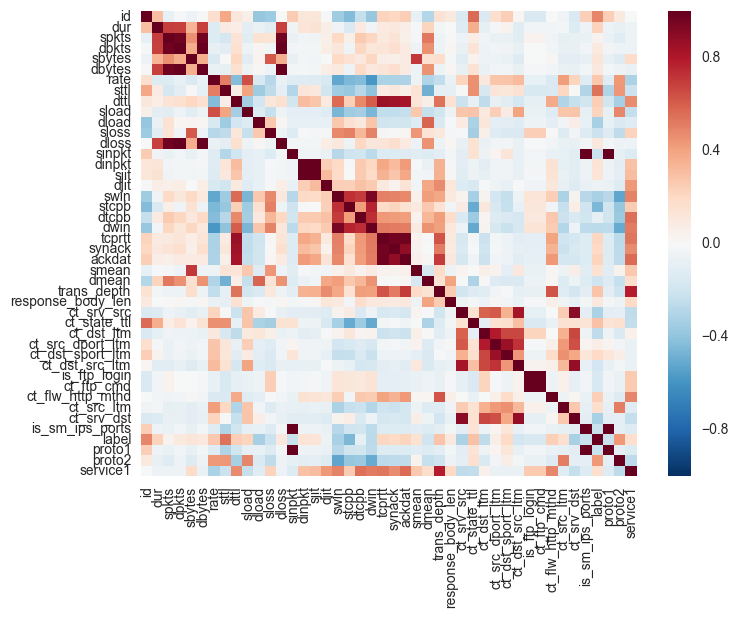

In [15]:
def plotCorrelations(data):
    plt.figure(figsize=(8, 6), dpi=500)
    corr = data.corr()
    sns.heatmap(corr, 
                xticklabels=corr.columns.values,
                yticklabels=corr.columns.values)
    
plotCorrelations(train_df)

In [16]:
import sklearn.decomposition

def performPCA():
    global X_train
    global X_test
    pca = sklearn.decomposition.PCA(n_components = 30)
    pca.fit(X_train)
    X_train = pca.transform(X_train)
    X_test = pca.transform(X_test)
    
#performPCA()

### Normalize features

In [17]:
def featureNormalization():
    global X_train
    global X_test
    
    scaler = skpre.StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
#featureNormalization()

## 3.1 - Model selection based on which models do best in CV using default settings:

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier().fit(X_train, Y_train)

In [ ]:
X_train.columns.values

In [ ]:
rf.feature_importances_

In [ ]:
fe_v = [ 0.02744583,  0.15915509,  0.08051205,  0.04447052,  0.04513294,
        0.04927782,  0.02358031,  0.03260846,  0.04214492,  0.03326136,
        0.02448847,  0.02473819,  0.01179376,  0.04341354,  0.0080685 ,
        0.01392277,  0.00560562,  0.04049034,  0.02264503,  0.00721319,
        0.01633885,  0.01084221,  0.00328429,  0.03949145,  0.03993958,
        0.0446234 ,  0.0149503 ,  0.02259267,  0.02316186,  0.04480668]

fe_n = ['dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes',
       'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss',
       'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin',
       'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
       'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm',
       'ct_srv_dst', 'is_sm_ips_ports']

features = []
for i in range(0, len(fe_v)):
    features.append((fe_v[i], fe_n[i]))
    
features.sort(key = lambda x: x[0], reverse = True)
features

LR: 0.830000 (0.131482)
LDA: 0.855500 (0.148903)
KNN: 0.811625 (0.178227)
CART: 0.865000 (0.118427)
NB: 0.839750 (0.118038)


C:\Users\migsa\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\migsa\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\migsa\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\migsa\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\migsa\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\migsa\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\migsa\Anacond

NN: 0.664375 (0.137103)
RF: 0.958500 (0.062502)
AB: 0.946500 (0.071878)
XGB: 0.948750 (0.069922)


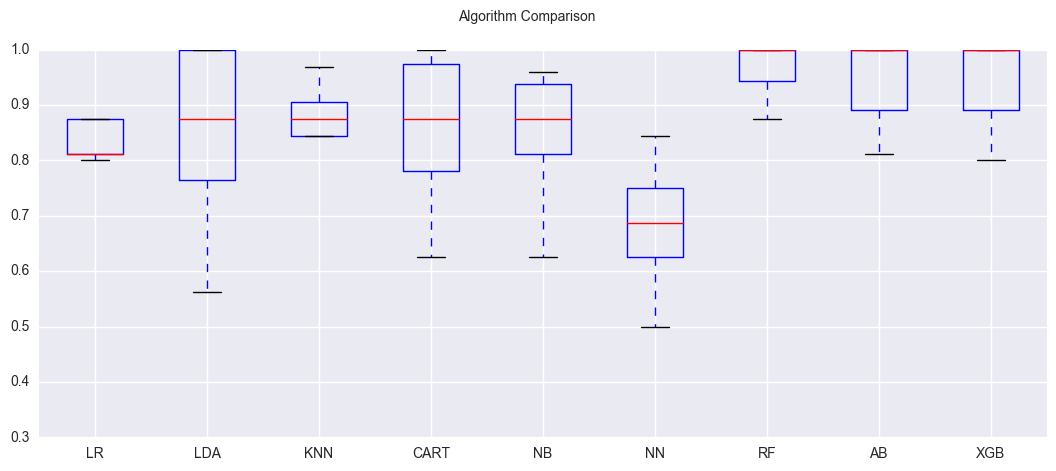

In [20]:
#inspired in http://machinelearningmastery.com/compare-machine-learning-algorithms-python-scikit-learn/

import sklearn.model_selection as mds
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import xgboost as xgb

def modelSelection():

    # prepare data

    #Y_train = train_df[:,-1]
    #X_train = train_df[:,:-1]

    #Y_train = train_df[len(train_df.columns)-1]
    #X_train = train_df.drop(len(train_df.columns)-1,axis=1)

    # prepare configuration for cross validation test harness
    num_folds = 10

    # prepare models
    models = []
    models.append(('LR', LogisticRegression(random_state = 2)))
    models.append(('LDA', LinearDiscriminantAnalysis()))
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('CART', DecisionTreeClassifier(random_state = 2)))
    models.append(('NB', GaussianNB()))
    #models.append(('SVM-Linear', SVC(kernel="linear")))
    #models.append(('SVM-Poly', SVC(kernel="poly")))
    #models.append(('SVM-RBF', SVC(kernel="rbf", random_state = 2)))
    models.append(('NN', MLPClassifier(random_state = 2))) 
    models.append(('RF', RandomForestClassifier(criterion="entropy", n_estimators=47, random_state = 2)))
    models.append(('AB', AdaBoostClassifier(random_state = 2)))
    models.append(('XGB', xgb.XGBClassifier()))

    # evaluate each model in turn
    results = []
    scoring = 'roc_auc' # try with 'roc_auc', f1'

    for model_name, model in models:
        kfold = mds.StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=2)
        cv_results = mds.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
        results.append({"name": model_name, "cv_results": cv_results, "mean": cv_results.mean(), "std": cv_results.std()})
        print("%s: %f (%f)" % (model_name, cv_results.mean(), cv_results.std()))

    # boxplot algorithm comparison
    fig = plt.figure(figsize=(13, 5), dpi=500)
    fig.suptitle('Algorithm Comparison')
    ax = fig.add_subplot(111)
    plt.boxplot([x["cv_results"] for x in results])
    ax.set_xticklabels([x["name"] for x in results])
    plt.show()

    # order the models by the mean auc
    #results_by_strategy.sort(key=lambda x: x["mean"], reverse=True)
    #print([(x["name"], x["mean"]) for x in results])

modelSelection()

## 3.2 - Model selection based on anomaly detection techniques

In [ ]:
import sklearn.ensemble
import sklearn.covariance
from sklearn import svm
import sklearn.metrics

def modelSelectionAnomaly():
    np.random.seed(2)
    ids_not_anomaly = np.random.choice(range(0, X_train.shape[0]), size = 41, replace = False)
    X_train_normal = X_train.values[ids_not_anomaly, :]
    Y_train_normal = Y_train[ids_not_anomaly]
    
    #model = sklearn.ensemble.IsolationForest(n_estimators = 60, contamination = 0.4, random_state = 2)
    model = svm.OneClassSVM(nu=0.3, kernel="linear", gamma=0.1, random_state = 2)
    #model = svm.OneClassSVM(nu=0.07, kernel="rbf", gamma=0.4, random_state = 2)
    #model = sklearn.covariance.EllipticEnvelope()
    
    model.fit(X_train[(Y_train != 1).values])
    anomaly_results = model.predict(X_train[(Y_train == 1).values])
    normal_results = model.predict(X_train_normal)
    
    print("%f %% of the anomalies were correctly classified" % (sum(anomaly_results == -1)/len(anomaly_results)))
    print("%f %% of the ok instances were correctly classified" % (sum(normal_results == 1)/len(normal_results)))
    print("ROC: %f" % 
          sklearn.metrics.roc_auc_score(np.append(np.repeat(-1, 41), np.repeat(1, 41)), np.append(anomaly_results, normal_results)))
    
modelSelectionAnomaly()

# 4 - Submission to Kaggle

In [19]:
from sklearn.ensemble import RandomForestClassifier

# choose algorithm
def makeSubmissionKaggle(algorithm):
    algorithm.fit(X_train, Y_train)
    Y_pred = algorithm.predict(X_test)
    Y_pred = Y_pred.astype(int)

    # save data to CSV
    saveDataToCSV(Y_pred)
    
def makeSubmissionAnomalyKaggle(algorithm):
    algorithm.fit(X_train, Y_train)
    Y_pred = algorithm.predict(X_test)
    Y_pred = Y_pred.astype(int)
    Y_pred = [1 if x == 1 else 0 for x in Y_pred]

    # save data to CSV
    saveDataToCSV(Y_pred)
    
#makeSubmissionKaggle("07-spec-mean", xgb.XGBClassifier( learning_rate=0.01, n_estimators=5000, max_depth=7,
#                      min_child_weight=1, gamma=0, subsample=0.55, colsample_bytree=0.85,
#                      reg_alpha=1e-5, objective= 'binary:logistic', scale_pos_weight=1, seed=2))

makeSubmissionKaggle(RandomForestClassifier(criterion="entropy", n_estimators=47, random_state = 2))
#makeSubmissionKaggle(xgb.XGBClassifier())

#makeSubmissionKaggle("09-spec-min", LinearDiscriminantAnalysis(n_components = 1, shrinkage = "auto", solver="lsqr"))
#makeSubmissionKaggle(RandomForestClassifier(criterion = 'entropy', max_features = 'log2', n_estimators = 630))
#makeSubmissionKaggle(RandomForestClassifier(criterion = 'entropy', max_features = 'log2', n_estimators = 310))
#makeSubmissionAnomalyKaggle(svm.OneClassSVM(nu=0.07, kernel="linear", gamma=0.1, random_state = 2))
#makeSubmissionKaggle(svm.OneClassSVM(nu=0.07, kernel="poly", gamma=0.1, random_state = 2))
#makeSubmissionAnomalyKaggle(sklearn.ensemble.IsolationForest(contamination = 0.4, random_state = 2))
#makeSubmissionKaggle(RandomForestClassifier())